# Appliquer votre méthodologie sur le jeu de données de détection d’intrusions dans les réseaux (Kddcup99). 

<hr>

In [22]:

from utils import *
warnings.filterwarnings('ignore')

In [23]:
# Charger le dataset
df = pd.read_csv('../data/csv/KDDCup99.csv', sep=',')
print("Labels uniques avant transformation :", df['label'].unique())


Labels uniques avant transformation : ['normal' 'buffer_overflow' 'loadmodule' 'perl' 'neptune' 'smurf'
 'guess_passwd' 'pod' 'teardrop' 'portsweep' 'ipsweep' 'land' 'ftp_write'
 'back' 'imap' 'satan' 'phf' 'nmap' 'multihop' 'warezmaster' 'warezclient'
 'spy' 'rootkit']


In [24]:
df['label'] = np.where(df['label'] == 'normal', 0, 1)
print("Labels après transformation :", df['label'].value_counts())

Labels après transformation : label
1    396743
0     97277
Name: count, dtype: int64


In [25]:
# Séparer les normales et les anomalies
X = df.drop(columns=['label'])
Y = df['label']

In [26]:
X_normal = X[Y == 0]
Y_normal = Y[Y == 0]

In [27]:

X_anomalie = X[Y == 1]
Y_anomalie = Y[Y == 1]

In [29]:
# Nombre d’échantillons pour équilibrer
taille_echantillon = min(len(X_normal), len(X_anomalie))
taille_echantillon

97277

In [30]:
X_normal_sampled = X_normal.sample(taille_echantillon, random_state=42)
Y_normal_sampled = Y_normal.sample(taille_echantillon, random_state=42)

In [31]:
X_anomalie_sampled = X_anomalie.sample(taille_echantillon, random_state=42)
Y_anomalie_sampled = Y_anomalie.sample(taille_echantillon, random_state=42)


In [32]:
# Fusion des datasets équilibrés
X_final = pd.concat([X_normal_sampled, X_anomalie_sampled], axis=0)
Y_final = pd.concat([Y_normal_sampled, Y_anomalie_sampled], axis=0)
print(f" Dataset équilibré : {sum(Y_final == 0)} normales | {sum(Y_final == 1)} anomalies")



 Dataset équilibré : 97277 normales | 97277 anomalies


In [33]:
# Encoder les variables catégoriques
X_final_encoded = pd.get_dummies(X_final, columns=['protocol_type', 'service', 'flag'])

In [34]:
# Appliquer PCA depuis `utils.py`
X_final_pca = apply_pca(X_final_encoded, n_components=30)

 PCA appliqué : 117 → 30 features


In [35]:
# Normalisation avec RobustScaler depuis `utils.py`
X_scaled = RobScaler(X_final_pca)

In [36]:
# Split dataset en train/test

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_final, test_size=0.1, stratify=Y_final, random_state=42)

print("Données prêtes pour l'entraînement")

Données prêtes pour l'entraînement


In [ ]:
# Définition de la pipeline
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10,
                             min_samples_leaf=5, max_features='sqrt', class_weight="balanced", random_state=1)

In [ ]:
# Pipeline configuration
P = Pipeline([
    ('ss', StandardScaler()),
    ('FS', SelectFromModel(clf, max_features=30)),
    ('classifier', clf)
])

# Entraînement du pipeline
P.fit(X_train, Y_train)
print("Pipeline entraînée avec succès !")


Pipeline entraînée avec succès !


In [38]:
with open('../artifacts/model.pkl', 'wb') as model_file:
    pickle.dump(P, model_file)

print("Modèle sauvegardé dans artifacts/model.pkl")

Modèle sauvegardé dans artifacts/model.pkl


In [39]:
# Prédictions
Y_pred = P.predict(X_test)

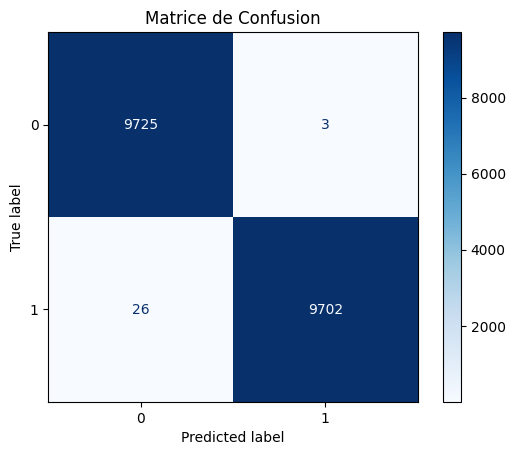

 Rapport de Classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9728
           1       1.00      1.00      1.00      9728

    accuracy                           1.00     19456
   macro avg       1.00      1.00      1.00     19456
weighted avg       1.00      1.00      1.00     19456



In [19]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.show()

# Rapport de classification
print(" Rapport de Classification :")
print(classification_report(Y_test, Y_pred))